# Checking for GPU availibility

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is available



# Importing Libraries

In [24]:
import os
import cv2
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
import os
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

# Counting number of files

In [3]:
# folder path
dir_path = 'DS/original'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 4080


# Data Preprocessing 

In [52]:
no_of_images = 4080
img_size = (256,256)
imgs_source = []
imgs_target = []

dir_source = "DS/original"
dir_target = "DS/bone_suppressed"

i = 0
for _, _, filenames in os.walk('DS/original'):
    for filename in filenames:
        print(i)
        i = i+1
        if(i > no_of_images):
            break
        img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
        img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
        # resizing images
        img_source = cv2.resize(img_source,img_size)
        img_target = cv2.resize(img_target,img_size)
    #     # normalizing images
        img_source = np.array(img_source)/255
        img_target = np.array(img_target)/255

        imgs_source.append(img_source)
        imgs_target.append(img_target)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
print(len(imgs_source))
print(len(imgs_target))

4080
4080


# Data Visualising 

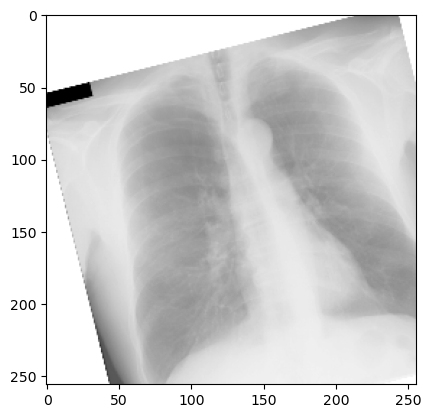

In [54]:
import matplotlib.pyplot as plt
plt.imshow(imgs_source[1],cmap='gray')
plt.gray()

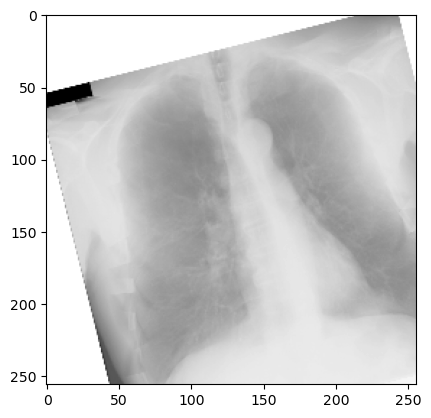

In [55]:
import matplotlib.pyplot as plt
plt.imshow(imgs_target[1])
plt.gray()

# Visualising Dataset 

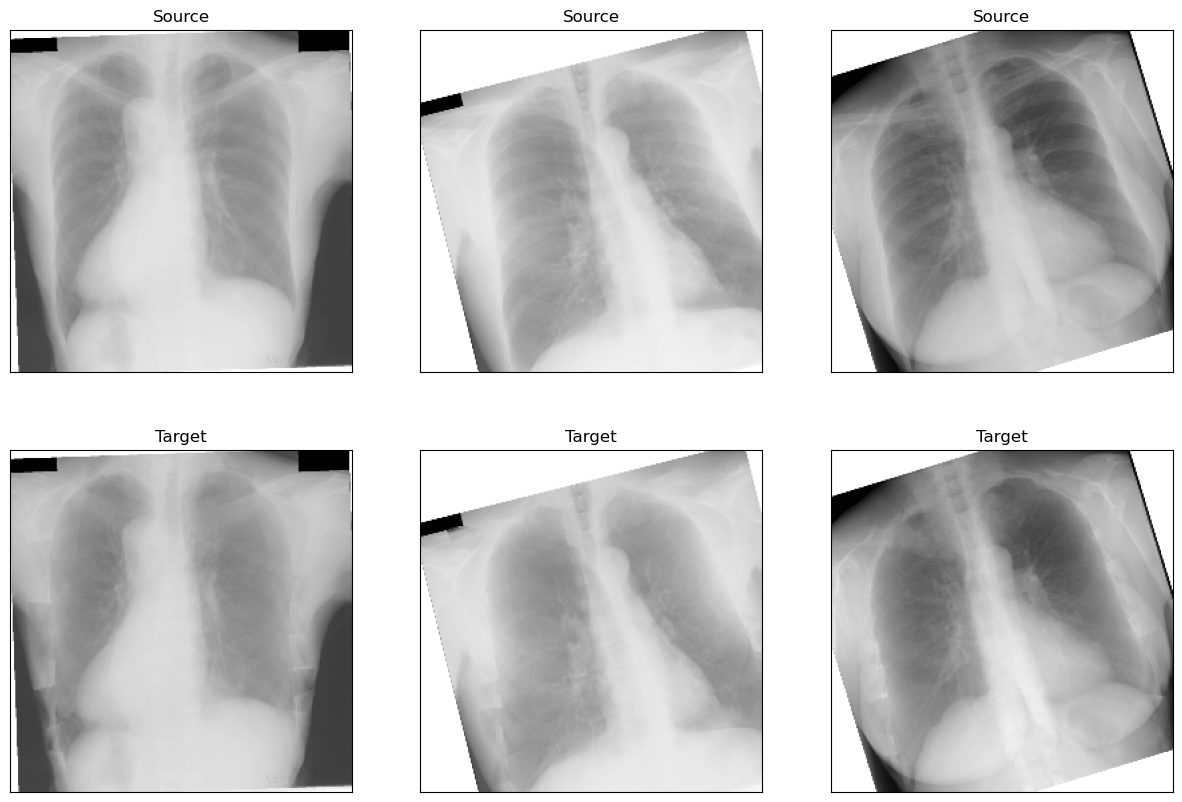

In [56]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(imgs_source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(imgs_target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

# Splitting dataset 

In [20]:
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

source = np.array(imgs_source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(imgs_target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

In [21]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(3264, 256, 256, 1) (816, 256, 256, 1) (3264, 256, 256, 1) (816, 256, 256, 1)


# AutoEncoder model

In [22]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [23]:
img_shape

(256, 256, 1)

# Compiling model 

In [24]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop() ,metrics=["mae","mse"])

2023-03-15 00:46:25.934340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 00:46:25.934891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [25]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0     

# Training Model

In [26]:
n_epoch = 50
n_batch = 32
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 1,
                                    validation_data = (source_test, target_test))

Epoch 1/50


2023-03-15 00:48:05.363693: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-15 00:48:07.317731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 0.0153 - mae: 0.0737 - mse: 0.0153

2023-03-15 00:50:27.006275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 152s 1s/step - loss: 0.0153 - mae: 0.0737 - mse: 0.0153 - val_loss: 0.0321 - val_mae: 0.1358 - val_mse: 0.0321
Epoch 2/50
102/102 [==============================] - 133s 1s/step - loss: 0.0053 - mae: 0.0448 - mse: 0.0053 - val_loss: 0.1523 - val_mae: 0.3244 - val_mse: 0.1523
Epoch 3/50
102/102 [==============================] - 132s 1s/step - loss: 0.0040 - mae: 0.0397 - mse: 0.0040 - val_loss: 0.0230 - val_mae: 0.1120 - val_mse: 0.0230
Epoch 4/50
102/102 [==============================] - 132s 1s/step - loss: 0.0028 - mae: 0.0341 - mse: 0.0028 - val_loss: 0.0116 - val_mae: 0.0788 - val_mse: 0.0116
Epoch 5/50
102/102 [==============================] - 132s 1s/step - loss: 0.0025 - mae: 0.0319 - mse: 0.0025 - val_loss: 0.0027 - val_mae: 0.0325 - val_mse: 0.0027
Epoch 6/50
102/102 [==============================] - 131s 1s/step - loss: 0.0023 - mae: 0.0307 - mse: 0.0023 - val_loss: 0.0038 - val_mae: 0.0384 - val_mse: 0.0038
Epoch 7/50
102/102 [=

# Checking loss

In [183]:
interval_epochs = [0, 49]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

epoch = 1	Loss = 0.02059	Validation_Loss = 0.03037
epoch = 50	Loss = 0.00092	Validation_Loss = 0.00124


# Plotting loss

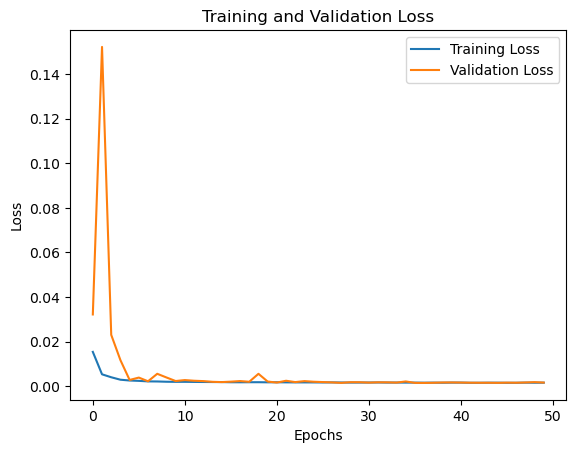

In [27]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

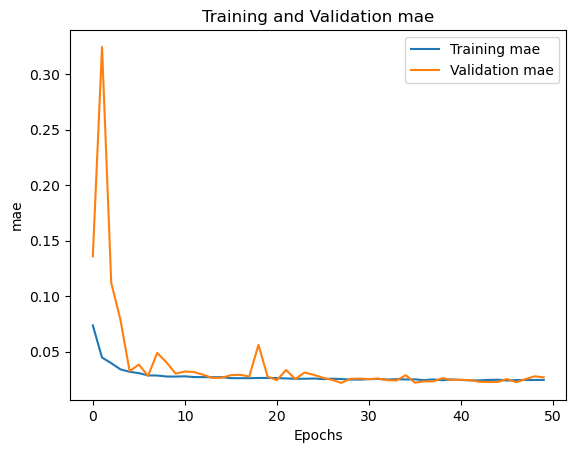

In [28]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mae'], label = 'Training mae')
plt.plot(n, autoencoder_train.history['val_mae'], label = 'Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

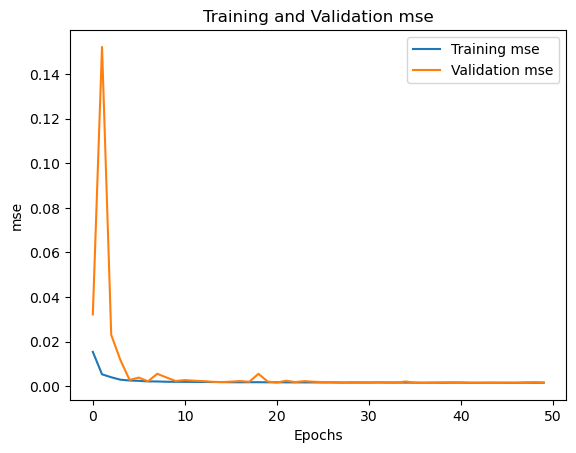

In [29]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mse'], label = 'Training mse')
plt.plot(n, autoencoder_train.history['val_mse'], label = 'Validation mse')
plt.title('Training and Validation mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()

In [185]:
# n = np.arange(0, n_epoch)
# plt.figure()
# plt.plot(n, autoencoder_train.history['accuracy'], label = 'Training Loss')
# plt.plot(n, autoencoder_train.history['val_accuracy'], label = 'Validation Loss')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

KeyError: 'accuracy'

<Figure size 640x480 with 0 Axes>

In [30]:
source_test.shape

(816, 256, 256, 1)

# Predicting output 

In [31]:
pred = autoencoder.predict(source_test)

2023-03-15 02:46:56.141709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 11s 377ms/step


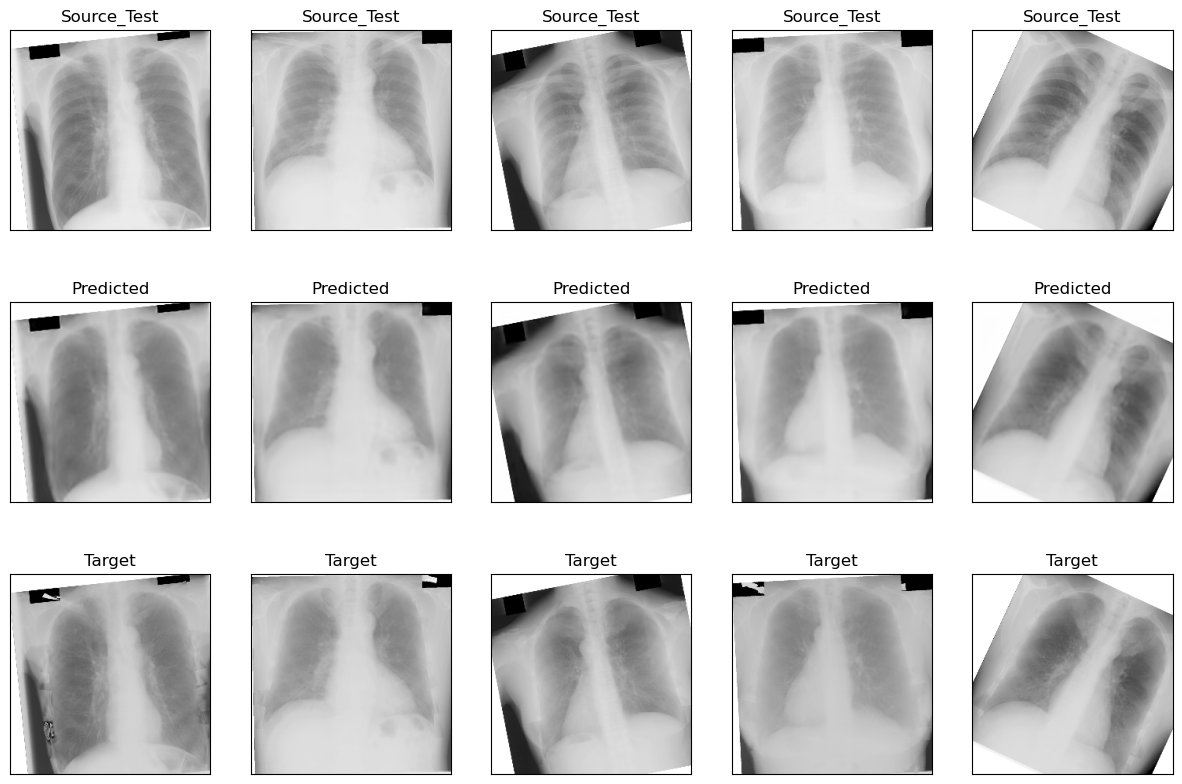

In [33]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')

    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

In [34]:
target_test.shape

(816, 256, 256, 1)

# Saving Model

In [59]:
# autoencoder.save('boneSupression.h5')

### Saving Model

In [ ]:
# autoencoder.save('180_auto_encoder.h5')

# Inference Code

In [66]:
from tensorflow import keras
model = keras.models.load_model('/Users/utkarsh/majorProject/finalModels/256AutoencoderFinal.h5')

In [84]:
image = '/Users/utkarsh/majorProject/sample images/1.png'
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)
def test(image):
    test1 = []
    test = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    # resizing images
    test = cv2.resize(test,(img_rows,img_cols))
    # normalizing images
    test = np.array(test)/255
    test1.append(test)   
    plt.imshow(test1[0])   
    test2 = np.array(test1).reshape(-1, img_rows, img_cols, img_channels)
    return test2

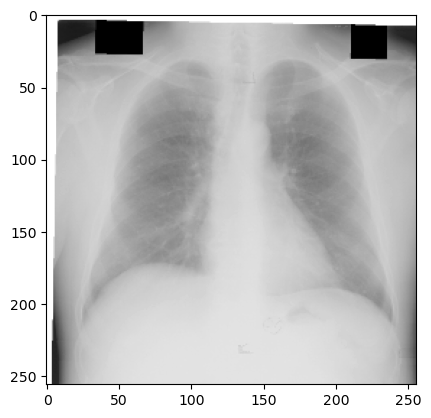

In [85]:
test_img = test(image)
plt.imshow(test_img[0],  cmap='gray')
plt.show()


1/1 [==============================] - 0s 89ms/step


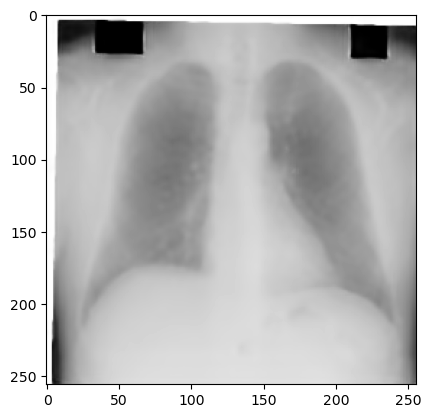

In [86]:
pred_img = model.predict(test_img)

plt.imshow(pred_img[0],  cmap='gray')
plt.show()
